# 라이브러리 로드

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json
import re

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from wordcloud import WordCloud

warnings.filterwarnings('ignore')
%matplotlib inline

# 데이터 로드
 * 사용한 데이터셋은 Kaggle 데이터셋의 Bag of Words Meets Bags of Popcorn데이터로 인터넷 영화 데이터베이스에서 나온 영화 평점 데이터이다.
 * 감정분석에 자주 활용되는 데이터이다.
 
 
 * columns
   * id : 고유 ID
   * sentiment : 감정의 긍정(1) 혹은 부정(0)
   * review : 영화에 대한 리뷰

In [2]:
train_data = pd.read_csv('data/Bag of Words Meets Bags of Popcorn/labeledTrainData.tsv', header=0, delimiter='\t', quoting=3)

In [3]:
train_data.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [4]:
print('전체 학습 데이터의 개수 :  {}'.format(len(train_data)))

전체 학습 데이터의 개수 :  25000


In [5]:
train_length = train_data['review'].apply(len) # 각각의 리뷰의 길이
train_length.head() 

0    2304
1     948
2    2451
3    2247
4    2233
Name: review, dtype: int64

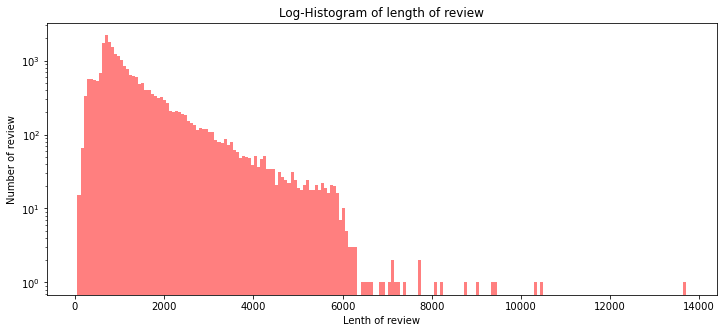

In [6]:
plt.figure(figsize=(12, 5))
plt.hist(train_length, bins=200, alpha=0.5, color='r', label='word')
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of length of review')
plt.xlabel('Lenth of review')
plt.ylabel('Number of review')
plt.show()

In [7]:
train_length.describe()

count    25000.000000
mean      1329.710560
std       1005.239246
min         54.000000
25%        705.000000
50%        983.000000
75%       1619.000000
max      13710.000000
Name: review, dtype: float64

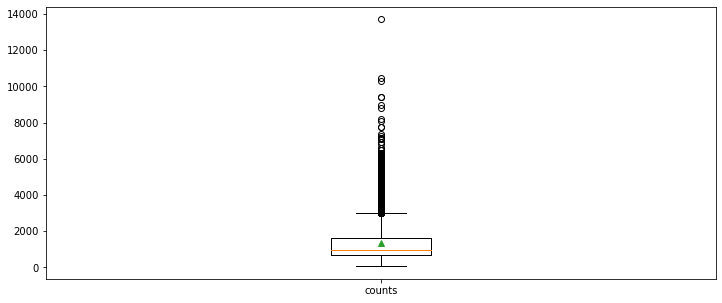

In [8]:
plt.figure(figsize=(12, 5))
plt.boxplot(train_length,labels=['counts'], showmeans=True)
plt.show()

(-0.5, 799.5, 599.5, -0.5)

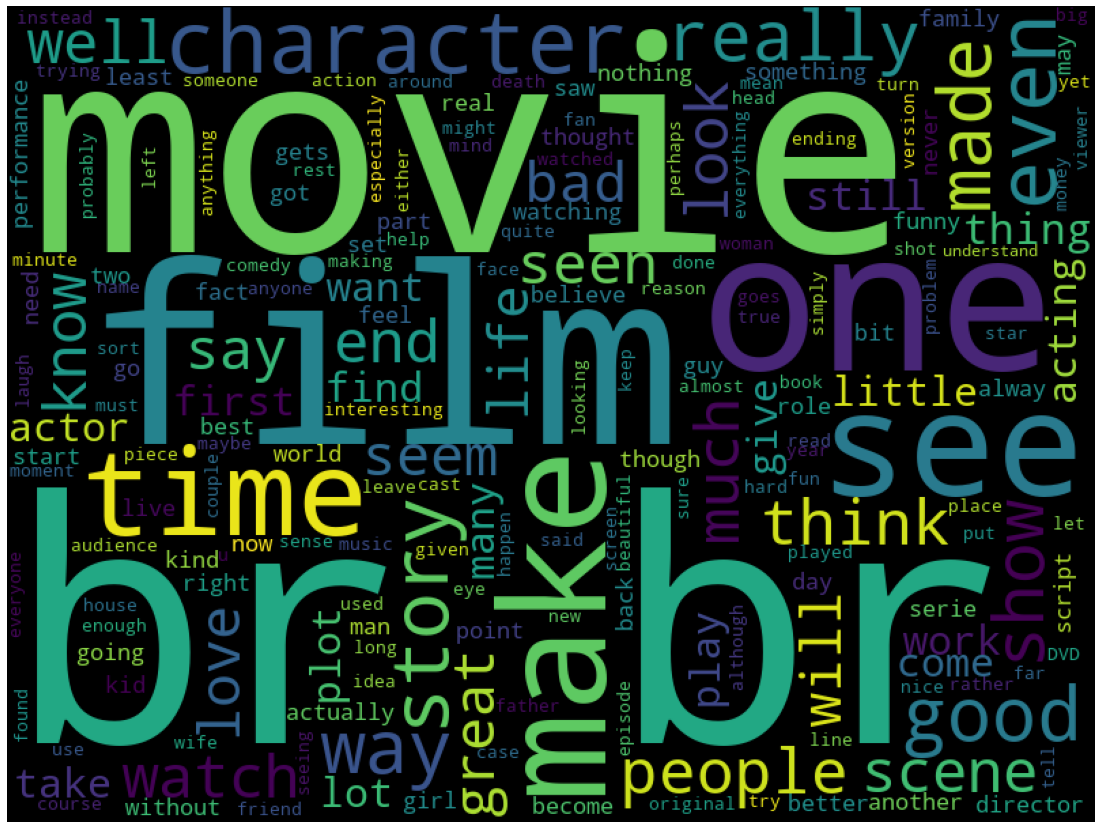

In [9]:
cloud = WordCloud(width=800, height=600).generate(" ".join(train_data['review']))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

긍정 리뷰 개수 : 12500
부정 리뷰 개수 : 12500


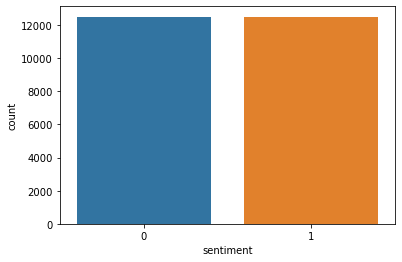

In [10]:
sns.countplot(train_data['sentiment'])
print('긍정 리뷰 개수 : {}'.format(train_data['sentiment'].value_counts()[1]))
print('부정 리뷰 개수 : {}'.format(train_data['sentiment'].value_counts()[0]))

In [11]:
train_word_counts = train_data['review'].apply(lambda x : len(x.split(' ')))

Text(0, 0.5, 'Number of reviews')

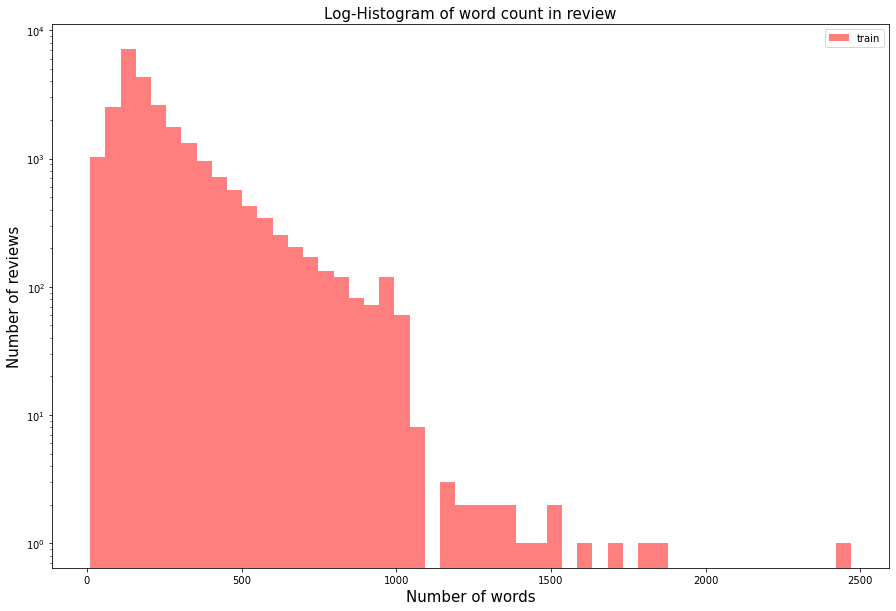

In [12]:
plt.figure(figsize=(15, 10))
plt.hist(train_word_counts, bins=50, alpha=0.5, facecolor='r', label='train')
plt.title('Log-Histogram of word count in review', fontsize=15)
plt.yscale('log', nonposy='clip')
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Number of reviews', fontsize=15)

In [13]:
train_word_counts.describe()

count    25000.000000
mean       233.786240
std        173.745845
min         10.000000
25%        127.000000
50%        174.000000
75%        284.000000
max       2470.000000
Name: review, dtype: float64

In [14]:
qmarks = np.mean(train_data['review'].apply(lambda x : '?' in x))
fullstop = np.mean(train_data['review'].apply(lambda x : '.' in x))
capital_first = np.mean(train_data['review'].apply(lambda x : x[0].isupper()))
capital = np.mean(train_data['review'].apply(lambda x : max([y.isupper() for y in x])))
numbers = np.mean(train_data['review'].apply(lambda x : max([y.isdigit() for y in x])))

In [15]:
print('물음표가 있는 질문: {:.2f}'.format(qmarks * 100))
print('마침표가 있는 질문: {:.2f}'.format(fullstop * 100))
print('첫 글자가 대문자인 질문: {:.2f}'.format(capital_first * 100))
print('대문자가 있는 질문: {:.2f}'.format(capital * 100))
print('숫자가 있는 질문: {:.2f}'.format(numbers * 100))

물음표가 있는 질문: 29.55
마침표가 있는 질문: 99.69
첫 글자가 대문자인 질문: 0.00
대문자가 있는 질문: 99.59
숫자가 있는 질문: 56.66


대문자는 소문자로 바꾸고 특수 문자를 제거해서 학습을 해야한다.

# 데이터 전처리

In [16]:
def preprocessing(review, remove_stopwords=False) :
    # 불용어 제거는 옵션으로 선택 가능
    
    # HTML 태그 제거
    review_text = BeautifulSoup(review, 'html5lib').get_text()
    
    # 영어가 아닌 특수문자를 공백으로 바꾸기
    review_text = re.sub("[^a-zA-Z]", " ", review_text)
    
    # 대문자를 소문자로 바꾸고 공백 단위로 텍스트는 나눠서 리스트로 만든다.
    words = review_text.lower().split()
    
    if remove_stopwords :
        # 불용어 제거
        
        # 영어 불용어 불러오기
        stops = set(stopwords.words('english'))
        
        #불용어가 아닌 단어로 이뤄진 새로운 리스트 생성
        words = [w for w in words if not w in stops]
        
        # 단어 리스트를 공백을 넣어서 하나의 글로 합친다.
        clean_review = ' '.join(words)
    
    else : # 불용어를 제거하지 않을 때
        clean_review = ' '.join(words)
        
    return clean_review

In [17]:
clean_train_reviews = []
for review in train_data['review'] :
    clean_train_reviews.append(preprocessing(review, remove_stopwords=True))

clean_train_reviews[0]

'stuff going moment mj started listening music watching odd documentary watched wiz watched moonwalker maybe want get certain insight guy thought really cool eighties maybe make mind whether guilty innocent moonwalker part biography part feature film remember going see cinema originally released subtle messages mj feeling towards press also obvious message drugs bad kay visually impressive course michael jackson unless remotely like mj anyway going hate find boring may call mj egotist consenting making movie mj fans would say made fans true really nice actual feature film bit finally starts minutes excluding smooth criminal sequence joe pesci convincing psychopathic powerful drug lord wants mj dead bad beyond mj overheard plans nah joe pesci character ranted wanted people know supplying drugs etc dunno maybe hates mj music lots cool things like mj turning car robot whole speed demon sequence also director must patience saint came filming kiddy bad sequence usually directors hate workin

In [18]:
clean_train_df = pd.DataFrame({'review':clean_train_reviews, 'sentiment':train_data['sentiment']})

In [19]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_reviews)
text_sequences = tokenizer.texts_to_sequences(clean_train_reviews)
print(text_sequences[0])

[404, 70, 419, 8815, 506, 2456, 115, 54, 873, 516, 178, 18686, 178, 11242, 165, 78, 14, 662, 2457, 117, 92, 10, 499, 4074, 165, 22, 210, 581, 2333, 1194, 11242, 71, 4826, 71, 635, 2, 253, 70, 11, 302, 1663, 486, 1144, 3265, 8815, 411, 793, 3342, 17, 441, 600, 1500, 15, 4424, 1851, 998, 146, 342, 1442, 743, 2424, 4, 8815, 418, 70, 637, 69, 237, 94, 541, 8815, 26055, 26056, 120, 1, 8815, 323, 8, 47, 20, 323, 167, 10, 207, 633, 635, 2, 116, 291, 382, 121, 15535, 3315, 1501, 574, 734, 10013, 923, 11578, 822, 1239, 1408, 360, 8815, 221, 15, 576, 8815, 22224, 2274, 13426, 734, 10013, 27, 28606, 340, 16, 41, 18687, 1500, 388, 11243, 165, 3962, 8815, 115, 627, 499, 79, 4, 8815, 1430, 380, 2163, 114, 1919, 2503, 574, 17, 60, 100, 4875, 5100, 260, 1268, 26057, 15, 574, 493, 744, 637, 631, 3, 394, 164, 446, 114, 615, 3266, 1160, 684, 48, 1175, 224, 1, 16, 4, 8815, 3, 507, 62, 25, 16, 640, 133, 231, 95, 7426, 600, 3439, 8815, 37248, 1864, 1, 128, 342, 1442, 247, 3, 865, 16, 42, 1487, 997, 2333, 12

In [20]:
word_vocab = tokenizer.word_index
word_vocab["<PAD>"] = 0 # 단어 패딩용

In [21]:
print('전체 단어 개수: ',len(word_vocab))

전체 단어 개수:  74066


In [40]:
data_configs = {}

data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(word_vocab)

In [41]:
MAX_SEQUENCE_LENGTH = 174 # 문장 최대 길이(문장의 단어 갯수 중간값)

train_inputs = pad_sequences(text_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

print('Shape of train data: ', train_inputs.shape)

Shape of train data:  (25000, 174)


In [24]:
train_labels = np.array(train_data['sentiment'])
print('Shape of lable tensor: ', train_labels.shape)

Shape of lable tensor:  (25000,)


In [25]:
DATA_IN_PATH = './data_in/'
TRAIN_INPUT_DATA = 'train_input.npy'
TRAIN_LABEL_DATA = 'train_label.npy'
TRAIN_CLEAN_DATA = 'train_clean.csv'
DATA_CONFIGS = 'data_config.json'

if not os.path.exists(DATA_IN_PATH) :
    os.makedirs(DATA_IN_PATH)

In [26]:
# 전처리된 데이터를 넘파이 형태로 저장
np.save(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'wb'), train_inputs)
np.save(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'wb'), train_labels)

# 정제된 텍스트를 CSV 형테로 저장
clean_train_df.to_csv(DATA_IN_PATH + TRAIN_CLEAN_DATA, index=False)

# 데이터 사전을 JSON 형태로 저장
json.dump(data_config, open(DATA_IN_PATH + DATA_CONFIGS, 'w'), ensure_ascii=False)

In [27]:
test_data = pd.read_csv(DATA_IN_PATH + 'testData.tsv', header=0, delimiter='\t', quoting=3)

In [28]:
clean_test_reviews = []
for review in test_data['review'] :
    clean_test_reviews.append(preprocessing(review, remove_stopwords=True))

clean_test_df = pd.DataFrame({'review':clean_test_reviews, 'id':test_data['id']})
test_id = np.array(test_data['id'])

text_sequences = tokenizer.texts_to_sequences(clean_test_reviews)
test_input = pad_sequences(text_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [29]:
TEST_INPUT_DATA = 'test_input.npy'
TEST_ID_DATA = 'test_id.npy'
TEST_CLEAN_DATA = 'test_clean.csv'

np.save(open(DATA_IN_PATH + TEST_INPUT_DATA, 'wb'), test_input)
np.save(open(DATA_IN_PATH + TEST_ID_DATA, 'wb'), test_id)
clean_test_df.to_csv(DATA_IN_PATH + TEST_CLEAN_DATA, index=False)

# Modeling

In [30]:
train_data = pd.read_csv(DATA_IN_PATH + TRAIN_CLEAN_DATA)

reviews = list(train_data['review'])
sentiments = list(train_data['sentiment'])

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df = 0.0, analyzer='char', sublinear_tf=True, ngram_range=(1,3), max_features=5000)

X = vectorizer.fit_transform(reviews)

In [43]:
features = vectorizer.get_feature_names()

In [44]:
from sklearn.model_selection import train_test_split

y = np.array(sentiments)

X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
from sklearn.linear_model import LogisticRegression

lgs = LogisticRegression(class_weight='balanced')
lgs.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [46]:
predicted = lgs.predict(X_eval)

In [47]:
print('Accuracy: %f' % lgs.score(X_eval, y_eval))

Accuracy: 0.859800


In [48]:
TEST_CLEAN_DATA = 'test_clean.csv'
test_data = pd.read_csv(DATA_IN_PATH + TEST_CLEAN_DATA)

In [49]:
test_data

,review,id
0,naturally film main themes mortality nostalgia...,"""12311_10"""
1,movie disaster within disaster film full great...,"""8348_2"""
2,movie kids saw tonight child loved one point k...,"""5828_4"""
3,afraid dark left impression several different ...,"""7186_2"""
4,accurate depiction small time mob life filmed ...,"""12128_7"""
...,...,...
24995,sony pictures classics looking sony got rights...,"""2155_10"""
24996,always felt ms merkerson never gotten role fit...,"""59_10"""
24997,disappointed movie familiar case read mark fuh...,"""2531_1"""
24998,opening sequence filled black white shots remi...,"""7772_8"""


In [50]:
testDataVecs = vectorizer.transform(test_data['review'])

In [51]:
test_predicted = lgs.predict(testDataVecs)
print(test_predicted)

[1 0 1 ... 0 1 0]


In [53]:
DATA_OUT_PATH = './data_out/'

if not os.path.exists(DATA_OUT_PATH):
    os.makedirs(DATA_OUT_PATH)

answer_dataset = pd.DataFrame({'id': test_data['id'], 'sentiment': test_predicted})
answer_dataset.to_csv(DATA_OUT_PATH + 'lgs_tfidf_answer.csv', index=False, quoting=3)